<a href="https://colab.research.google.com/github/Splav12341/H-M_kaggle_competiton/blob/main/colour_group_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import numpy as np
import time
from collections import defaultdict
from tqdm import tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
device

device(type='cuda')

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!nvidia-smi

Wed Apr 27 17:58:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.129      Driver Version: 410.129      CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:59:00.0 Off |                    0 |
| N/A   35C    P0    49W / 312W |     13MiB / 32480MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
DATA_PATH = r"./../H&M/images"

NUM_WORKERS = 8
SIZE_H = SIZE_W = 256

EPOCH_NUM = 30
BATCH_SIZE = 250

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

In [ ]:
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset

In [ ]:
import pandas as pd
df = pd.read_csv('./../H&M/articles.csv')
df = df.astype({'article_id': 'str'})

# Make Dataset

In [ ]:
class DatasetImageFolder(torch.utils.data.Dataset):
    def __init__(self, DATA_PATH: str, df, transform):
        super(DatasetImageFolder, self).__init__()
        self.root = DATA_PATH
        self.transform = transform
        self.class_names = []
        self.images_filepaths = []
 
        for directory in tqdm(sorted(os.listdir(os.path.join(DATA_PATH)))):
            for fname in os.listdir(os.path.join(DATA_PATH + '/' + directory)):
                for row in df.values:
                    if fname[1:-4] == row[0]:
                        self.images_filepaths.append(row[0])
                        self.class_names.append(row[1])
                        df = df.drop(df[df.article_id == row[0]].index)
                        break
                        
        self.target_dict = dict()
        for idx, label in enumerate(np.unique(self.class_names)):
            self.target_dict[label] = idx

    def __len__(self):
        return len(self.images_filepaths)
 
    def __getitem__(self, idx):
        
        image_filepath = ('./../H&M/images/' + '0' + str(test_dataset.images_filepaths[idx])[:2] + '/0' + 
                                str(test_dataset.images_filepaths[idx]) +'.jpg')
        image = Image.open(image_filepath)
     
        label = torch.tensor(self.target_dict[self.class_names[idx]])
        try:
            image = self.transform(image)
        except RuntimeError:
            print('aaaaa:', image_filepath)
            
            image = torch.zeros((3, 256, 256))
            label = torch.tensor(0)
        return image, label, self.images_filepaths[idx]

In [ ]:
column = 'colour_group_code'
test_dataset = DatasetImageFolder(DATA_PATH, df[['article_id', column]], transformer)

100%|██████████| 86/86 [12:00<00:00,  8.38s/it]


## pseudo balance classes

In [ ]:
unique, counts = np.unique(test_dataset.class_names, return_counts=True)

In [ ]:
counts

array([   28,   104,    30,   696,    91,  1359,  2097,  4476,  2727,
       22565,  9501,  2722,  3341,  2708,  1079,   226,  1459,  2761,
         225,   982,  1639,   574,   151,  1508,   771,   883,   114,
         282,  3045,  2335,   741,  5776,  2055,   815,    45,   548,
         182,   314,    51,  3004,  3304, 12129,    14,  1024,   433,
         471,   126,   679,   811,  2099])

In [ ]:
unique

array([-1,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 17,
       19, 20, 21, 22, 23, 30, 31, 32, 33, 40, 41, 42, 43, 50, 51, 52, 53,
       60, 61, 62, 63, 70, 71, 72, 73, 80, 81, 82, 83, 90, 91, 92, 93])

In [ ]:
df[column].value_counts()

 9     22670
 73    12171
 10     9542
 51     5811
 7      4487
 12     3356
 72     3308
 42     3056
 71     3012
 19     2767
 8      2731
 11     2726
 13     2712
 43     2340
 93     2106
 6      2105
 52     2063
 22     1645
 31     1520
 17     1471
 5      1377
 14     1084
 81     1027
 21      984
 33      886
 53      818
 92      815
 32      779
 50      750
 3       709
 91      681
 23      574
 61      553
 83      473
 82      435
 63      315
 41      285
 15      226
 20      225
 62      182
 30      153
 90      129
 40      114
 1       105
 4        94
 70       51
 60       46
 2        31
-1        28
 80       14
Name: colour_group_code, dtype: int64

## choose balance_number

In [ ]:
d = dict()
balance_number = 2000.

# colour_group_code
# balance_number = 1000.

# graphical_appearance_no
# balance_number = 3000.


for idx, value in enumerate(counts):
    weight = int(balance_number/value)
    d[unique[idx]] = weight
print(d)

{-1: 71, 1: 19, 2: 66, 3: 2, 4: 21, 5: 1, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0, 13: 0, 14: 1, 15: 8, 17: 1, 19: 0, 20: 8, 21: 2, 22: 1, 23: 3, 30: 13, 31: 1, 32: 2, 33: 2, 40: 17, 41: 7, 42: 0, 43: 0, 50: 2, 51: 0, 52: 0, 53: 2, 60: 44, 61: 3, 62: 10, 63: 6, 70: 39, 71: 0, 72: 0, 73: 0, 80: 142, 81: 1, 82: 4, 83: 4, 90: 15, 91: 2, 92: 2, 93: 0}


## Balanced dataset 

In [ ]:
class BalancedDatasetImageFolder(torch.utils.data.Dataset):
    def __init__(self, DATA_PATH: str, transform, class_names, images_filepaths, target_dict):
        super().__init__()
        self.root = DATA_PATH
        self.transform = transform
        self.class_names = class_names.copy()
        self.images_filepaths = images_filepaths.copy()
                        
        self.target_dict = target_dict.copy()

    def __len__(self):
        return len(self.images_filepaths)
 
    def __getitem__(self, idx):
        image_filepath = ('./../H&M/images/' + '0' + str(self.images_filepaths[idx])[:2] + '/0' + 
                                str(self.images_filepaths[idx]) +'.jpg')
        image = Image.open(image_filepath)
        label = torch.tensor(self.target_dict[self.class_names[idx]])
        try:
            image = self.transform(image)
        except RuntimeError:
            print('aaaaa:', image_filepath)
            
            image = torch.zeros((3, 256, 256))
            label = torch.tensor(0)
        return image, label, self.images_filepaths[idx]

In [ ]:
balanced_dataset = BalancedDatasetImageFolder(DATA_PATH, transformer, test_dataset.class_names, test_dataset.images_filepaths, test_dataset.target_dict)

In [ ]:
class_names = []
images_filepaths = []
for name, path in tqdm(zip(balanced_dataset.class_names, balanced_dataset.images_filepaths)):
    
    tmp_names = []
    tmp_paths = []
    if d[name]>0:
        tmp_names.append(name)
        tmp_names = tmp_names*d[name]
        tmp_paths.append(path)
        tmp_paths = tmp_paths*d[name]

        class_names.extend(tmp_names)
        images_filepaths.extend(tmp_paths)
        
balanced_dataset.class_names.extend(class_names)
balanced_dataset.images_filepaths.extend(images_filepaths)    

105100it [00:00, 886058.82it/s]


## checking

In [ ]:
unique, counts = np.unique(balanced_dataset.class_names, return_counts=True)

In [ ]:
counts

array([ 2016,  2080,  2010,  2088,  2002,  2718,  2097,  4476,  2727,
       22565,  9501,  2722,  3341,  2708,  2158,  2034,  2918,  2761,
        2025,  2946,  3278,  2296,  2114,  3016,  2313,  2649,  2052,
        2256,  3045,  2335,  2223,  5776,  2055,  2445,  2025,  2192,
        2002,  2198,  2040,  3004,  3304, 12129,  2002,  2048,  2165,
        2355,  2016,  2037,  2433,  2099])

In [ ]:
unique, counts = np.unique(test_dataset.class_names, return_counts=True)

In [ ]:
counts

array([   28,   104,    30,   696,    91,  1359,  2097,  4476,  2727,
       22565,  9501,  2722,  3341,  2708,  1079,   226,  1459,  2761,
         225,   982,  1639,   574,   151,  1508,   771,   883,   114,
         282,  3045,  2335,   741,  5776,  2055,   815,    45,   548,
         182,   314,    51,  3004,  3304, 12129,    14,  1024,   433,
         471,   126,   679,   811,  2099])

# DataLoader

In [ ]:
img, label, images_filepaths = balanced_dataset[0]
print(img.shape)
print(label)

torch.Size([3, 256, 256])
tensor(9)


In [ ]:
NUM_WORKERS=8
train_loader = DataLoader(balanced_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

emb_train_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

In [ ]:
# train_iter = iter(train_loader)
# it = next(train_iter)
# print(len(it))
# print(it[0].shape)
# print(it[1])

## plot samples

In [ ]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch, images_filepaths = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = batch_gen.dataset.class_names
    for i in range(grid_size[0] * grid_size[1]):
        
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
#         sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        sample_title = 'Label = %s' % class_names[label_batch[i]]
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)

In [ ]:
# plot_from_batch_generator(train_loader)

## define num_classes

In [ ]:
NUM_CLASSES = len(np.unique(train_loader.dataset.class_names))

# Download model

In [ ]:
# !pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet

In [ ]:
# Load pre-trained model
# model_resnet18 = torchvision.models.resnet152(pretrained=True)
from collections import OrderedDict
model = EfficientNet.from_pretrained('efficientnet-b4')

# Disable gradient updates for all the layers except  the final layer
# YOUR CODE HERE
for p in model.parameters():
    p.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_feat = model._fc.in_features

# hid_size = 200
emb_size = 20
model._fc = nn.Linear(num_feat, emb_size)

model = nn.Sequential(OrderedDict([
          ('efficientnet', model),
          ('leaky_relu1', nn.LeakyReLU(0.3)),
          ('lin', nn.Linear(emb_size, NUM_CLASSES)),
          ('leaky_relu2', nn.LeakyReLU(0.3))
]))

# Use available device for calculations
model = model.to(device)

Loaded pretrained weights for efficientnet-b4


In [ ]:
!mkdir ./models
CHECKPOINT_PATH = "./models/save2"

mkdir: cannot create directory ‘./models’: File exists


In [ ]:
# torch.save(model.state_dict(),CHECKPOINT_PATH)
# model.load_state_dict(torch.load(CHECKPOINT_PATH))
# model = model.to(device)

In [ ]:
# model(it[0].to(device)).shape

## tensorboard

In [ ]:
# !rm -r ./runs/log

In [ ]:
# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter('runs/log2')

In [ ]:
# %reload_ext tensorboard
# %tensorboard --logdir=./runs --bind_all --port=6007# bind_all for remoted python
# # or use http://tpls-sgmta00001.sigma.sbrf.ru:6006/

## training

In [ ]:
from IPython.display import clear_output
import time
from sklearn.metrics import accuracy_score

def fit(model, epochs, lr):
    torch.cuda.empty_cache()
    
    opt = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.5, 0.999))
    train_losses = []
    accuracy = []
    start = time.time()
    i=0
    flag = False
    for epoch in range(epochs):
        model.train(True)
        for img, label, images_filepaths in tqdm(train_loader):
            clear_output(True)
            img = img.to(device)
            label = label.to(device)
            opt.zero_grad()
            preds = model(img).to(device)
            ce_loss = nn.CrossEntropyLoss()
            loss = ce_loss(preds, label)
            loss.backward()
            opt.step()
            tmp_loss = loss.item()
            train_losses.append(tmp_loss)
            
            end = time.time() - start
            
            acc = accuracy_score(label.cpu(), np.argmax(preds.cpu().detach().numpy(), axis=1))
            accuracy.append(acc)
            
            # if i%10==1:
            plt.plot(np.arange(0, len(train_losses)), train_losses, label=f'spent_time={end}, ep={epoch}')
            plt.legend()
            plt.show()

            plt.plot(np.arange(0, len(accuracy)), accuracy, label='accuracy')
            plt.legend()
            plt.show()
            
            if (np.mean(accuracy[-5:])>0.75):
                flag = True
            
            i+=1
        
        torch.save(model.state_dict(),CHECKPOINT_PATH)
        if flag == True:
            break
    model.train(False)
    return model

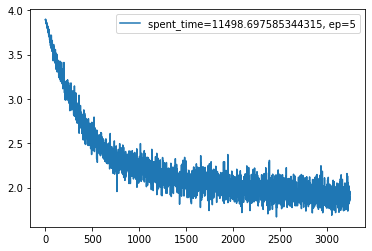

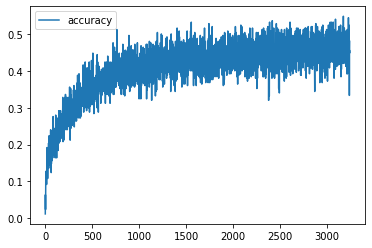

  0%|          | 3/648 [00:33<1:59:45, 11.14s/it]


KeyboardInterrupt: 

In [ ]:
EPOCH_NUM=100
model = fit(model, EPOCH_NUM , lr=0.0003)

In [ ]:
torch.save(model.state_dict(),CHECKPOINT_PATH)

In [ ]:
model.load_state_dict(torch.load(CHECKPOINT_PATH))
model = model.to(device)

# Make embeddings

In [ ]:
df = np.zeros((len(test_dataset.images_filepaths), emb_size+1))
i=0
for img, label, images_filepaths in tqdm(emb_train_loader):
    img = img.to(device)
    preds = model.efficientnet(img).cpu().detach().numpy()
    
    for k in range(img.shape[0]):
        df[i*BATCH_SIZE + k, 0] = int(images_filepaths[k])
        for m in range(emb_size):
            df[i*BATCH_SIZE + k, m+1] = preds[k,m:m+1][0]
    i+=1
    
df = pd.DataFrame(df)
print(df.shape)
df.head()

 11%|█▏        | 48/421 [02:57<08:07,  1.31s/it] 

aaaaa: ./../H&M/images/061/0616100001.jpg


100%|██████████| 421/421 [24:28<00:00,  3.49s/it]

(105100, 21)


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,568593004.0,1.467842,3.970417,6.125340,-0.189507,-1.584250,7.229694,-1.665498,-0.813880,-0.972181,...,4.445744,2.114445,2.641623,1.395574,-2.491008,3.702339,2.775120,3.470323,2.862988,-0.992524
1,639450001.0,-0.254361,2.531318,-1.763081,5.507886,2.556554,-1.420854,3.211045,3.442369,5.164075,...,1.930489,0.837425,4.025880,5.795096,4.829978,1.551886,-0.080440,1.784710,0.706856,0.988901
2,510075014.0,-4.188909,3.310985,0.479185,8.083498,5.236981,0.104801,-2.382178,1.942409,1.355643,...,0.347273,-5.613861,1.325653,4.182404,-1.939167,1.653908,2.426583,1.050490,0.830585,1.474581
3,635168015.0,-0.443159,2.806391,0.082961,3.926576,1.390461,-0.608195,1.383237,2.691496,1.011560,...,-1.315736,-1.362251,1.761591,2.603801,2.210498,0.606321,1.420433,1.230476,0.775410,1.080353
4,640733001.0,0.244673,-1.760099,1.701853,1.265867,-0.000304,0.085181,2.154590,1.277837,2.793372,...,1.598789,3.593164,1.092857,3.317524,2.020916,-0.570163,-1.404139,2.510555,-0.001487,-1.311058


In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,568593004.0,1.467842,3.970417,6.125340,-0.189507,-1.584250,7.229694,-1.665498,-0.813880,-0.972181,...,4.445744,2.114445,2.641623,1.395574,-2.491008,3.702339,2.775120,3.470323,2.862988,-0.992524
1,639450001.0,-0.254361,2.531318,-1.763081,5.507886,2.556554,-1.420854,3.211045,3.442369,5.164075,...,1.930489,0.837425,4.025880,5.795096,4.829978,1.551886,-0.080440,1.784710,0.706856,0.988901
2,510075014.0,-4.188909,3.310985,0.479185,8.083498,5.236981,0.104801,-2.382178,1.942409,1.355643,...,0.347273,-5.613861,1.325653,4.182404,-1.939167,1.653908,2.426583,1.050490,0.830585,1.474581
3,635168015.0,-0.443159,2.806391,0.082961,3.926576,1.390461,-0.608195,1.383237,2.691496,1.011560,...,-1.315736,-1.362251,1.761591,2.603801,2.210498,0.606321,1.420433,1.230476,0.775410,1.080353
4,640733001.0,0.244673,-1.760099,1.701853,1.265867,-0.000304,0.085181,2.154590,1.277837,2.793372,...,1.598789,3.593164,1.092857,3.317524,2.020916,-0.570163,-1.404139,2.510555,-0.001487,-1.311058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105095,910439002.0,-1.036296,-2.346099,1.240059,-4.820119,0.489179,0.164161,3.717622,2.561325,2.408957,...,1.927429,-2.175008,2.535063,2.283042,-1.565670,-1.233865,0.950978,6.371066,-0.800880,-4.149199
105096,828050002.0,6.541903,-2.903010,6.053606,5.117522,-2.435457,-0.399521,2.789445,4.742798,4.869843,...,3.161389,1.368923,-2.911216,6.167363,4.674146,5.463200,-0.207463,-0.657633,-0.339938,-4.399602
105097,637935001.0,-0.565408,4.175253,2.741917,5.590564,4.943574,-1.445582,0.437543,2.537083,5.571931,...,4.112484,-1.588542,4.645475,3.516471,3.426046,2.943505,0.815717,3.665178,2.310355,-0.750373
105098,874240002.0,2.580819,0.601560,0.071406,8.153777,0.427558,-4.409646,-1.974847,3.156410,3.373031,...,-0.674447,0.172492,-2.682840,6.462188,5.180929,2.404669,-2.376741,-1.741528,-0.448084,-4.044993


In [ ]:
df.to_csv('./checkpoint2.csv')